In [ ]:
# ! pip install fastBPE sacremoses

In [16]:
import torch
import os
import matplotlib.pyplot as plt

def load_lm(lang):
    assert lang in ["en", "de", "ru"]
    # Load an lang LM trained on WMT'19 News Crawl data
    return torch.hub.load('pytorch/fairseq', 'transformer_lm.wmt19.'+lang, tokenizer='moses', bpe='fastbpe')

def eval_lm(lm, lang, filepath, src_lang, n_samples):

    assert lang in ["en", "de", "ru"]
    assert lang != src_lang
    assert os.path.isfile(filepath)
    assert 0 < n_samples
    
    lm.eval()  # disable dropout
    if torch.cuda.is_available() :
        # Move model to GPU
        try : 
            lm.cuda()
        except RuntimeError : # CUDA out of memory
            print("CUDA out of memory")
    #else :
    #    lm.cpu()
  
    scores_per_lenght = {}
    positional_scores = []
    raw_scores        = []
    scores            = []

    with open(filepath, 'r', encoding="utf-8") as datasetfile :
        for line in datasetfile.readlines()[:n_samples]:
            # todo
            line = line[:512]
            
            """
            if len(lm.score(line)["tokens"]) > 10 :
                while len(lm.score(line)["tokens"]) % 10 != 0 :
                    line = line[:len(line)-1]
            """
            
            scores_tmp = lm.score(line)

            pos_scores = scores_tmp['positional_scores']
            positional_scores.append(pos_scores)
            raw_scores.append(scores_tmp["score"]) # scores_tmp["score"] is equal to scores_tmp['positional_scores'].mean()

            pos_score = pos_scores.mean().neg().exp()
            scores.append(pos_score)

            lenght = len(scores_tmp["tokens"])
            try :
                scores_per_lenght[lenght].append(pos_score)
            except KeyError:
                scores_per_lenght[lenght] = []
                scores_per_lenght[lenght].append(pos_score)
    scores_per_lenght = {lenght : torch.tensor(pos_score).mean() for lenght, pos_score in scores_per_lenght.items()}
    return scores_per_lenght, positional_scores, raw_scores, scores

In [17]:
def main(src_lang, n_samples, main_path) :
    scores_per_lenght, positional_scores, raw_scores, scores = eval_lm(
                              lm = en_lm, 
                              lang = "en", 
                              filepath = main_path + src_lang + ".txt", 
                              src_lang = src_lang,
                              n_samples = n_samples
                              )

    #print(scores_per_lenght)
    #print(positional_scores)
    #print(raw_scores)
    print(scores[:10])

    print("========================= ", src_lang)
    print(torch.tensor(scores).mean())
    print("=========================")

    x = sorted([i for i in scores_per_lenght.keys() 
              if i%10 == 0
              ])
    print(x)

    height = [float(torch.tensor(scores_per_lenght[key]).mean())  for key in x]
    print(height)


    f, ax = plt.subplots(figsize=(10,3))

    plt.bar(x = x, height = height, width = 8, label = "ppl")

    ax_ = [min(x), max(x), min(height), max(height)]
    print(ax_)

    plt.axis(ax_)      

    plt.xticks(x)    

    plt.xlabel("sentences lenghts")
    plt.ylabel("perplexity")
    plt.title("perplexity per sentences lenght")

    ax.legend(fontsize = 14)

    return scores_per_lenght

In [3]:
#en_lm = load_lm(lang = "en")

Using cache found in /home/jupyter/.cache/torch/hub/pytorch_fairseq_master


[tensor(5666.4375, device='cuda:0'), tensor(2867.6670, device='cuda:0'), tensor(23230.5957, device='cuda:0'), tensor(60627868., device='cuda:0'), tensor(3207.2363, device='cuda:0'), tensor(13477.5225, device='cuda:0'), tensor(1260.0389, device='cuda:0'), tensor(3598.2876, device='cuda:0'), tensor(3260.4316, device='cuda:0'), tensor(1682.7225, device='cuda:0')]
tensor(6068612.)
[10, 30, 40, 60, 80]
[13305.1181640625, 3598.28759765625, 4463.4345703125, 2275.19482421875, 1260.0389404296875]
[10, 80, 1260.0389404296875, 13305.1181640625]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[tensor(89.0129, device='cuda:0'), tensor(162.4275, device='cuda:0'), tensor(1554.1726, device='cuda:0'), tensor(794.1428, device='cuda:0'), tensor(293.7960, device='cuda:0'), tensor(124.3377, device='cuda:0'), tensor(50.6096, device='cuda:0'), tensor(299.8370, device='cuda:0'), tensor(278.7428, device='cuda:0'), tensor(37.8166, device='cuda:0')]
tensor(368.4896)
[20, 40, 50, 70, 90, 100, 130]
[657.4354858398438, 299.83697509765625, 278.7428283691406, 89.01290893554688, 162.42752075195312, 37.81658172607422, 50.6096305847168]
[20, 130, 37.81658172607422, 657.4354858398438]
[tensor(15.2604, device='cuda:0'), tensor(14.4851, device='cuda:0'), tensor(15.0473, device='cuda:0'), tensor(60.0423, device='cuda:0'), tensor(16.4272, device='cuda:0'), tensor(21.4380, device='cuda:0'), tensor(13.8370, device='cuda:0'), tensor(24.1483, device='cuda:0'), tensor(14.8592, device='cuda:0'), tensor(12.7428, device='cuda:0')]
tensor(20.8288)
[10, 50, 70, 90, 170, 210, 240, 270, 330]
[60.04230499267578, 2

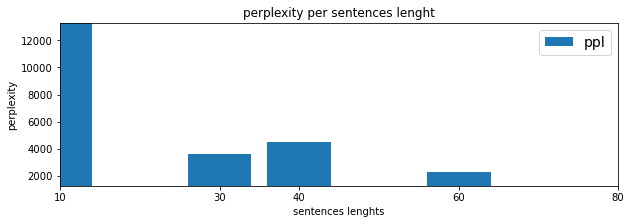

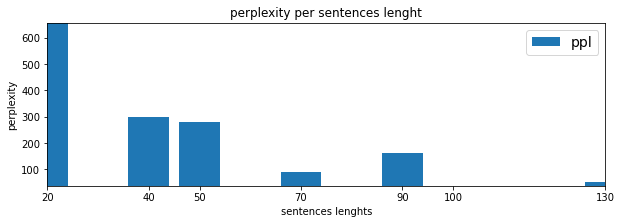

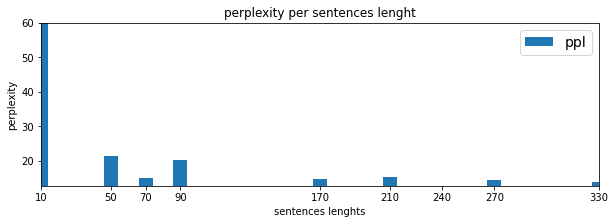

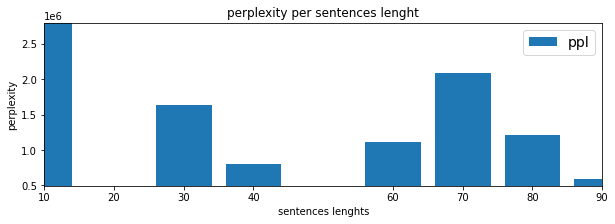

In [10]:
scores_per_lenght = {}
langs = ["de", "fr","ru","zh"]
for lang in langs :
    scores_per_lenght[lang] = main(src_lang = lang, n_samples = 10, main_path = "/home/jupyter/data/fairseq/test/")

In [ ]:
import itertools
a = sorted(
    set(
        itertools.chain.from_iterable(
            [scores_per_lenght[lg].keys() for lg in langs]
            )
        )
    )

In [ ]:
 #r = {lenght : ppl for lenght, ppl  }

for key in a :
    if all([key in scores_per_lenght[lg].keys() for lg in langs]) :
    max = 0
    lang = None
    for lg in langs :
        if scores_per_lenght[lg][key] > max :
            max = scores_per_lenght[lg][key]
            lang = lg
    print(lang)

[tensor(856.5319, device='cuda:0'), tensor(245.5427, device='cuda:0'), tensor(218640.0938, device='cuda:0'), tensor(87894.5469, device='cuda:0'), tensor(87894.5469, device='cuda:0'), tensor(44792.0273, device='cuda:0'), tensor(216054.3281, device='cuda:0'), tensor(221152.3750, device='cuda:0'), tensor(276990.7188, device='cuda:0'), tensor(45094.3672, device='cuda:0')]
=========================  de-en.de
tensor(303131.4375)
[]
[]


ValueError: min() arg is an empty sequence

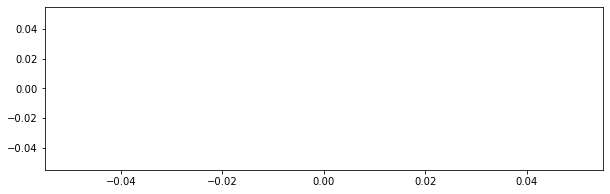

In [18]:
scores_per_lenghtp = {}
langsp = ["de-en.de", "en-fr.fr"]
for lang in langsp :
    scores_per_lenghtp[lang] = main(src_lang = lang, n_samples = 100,  main_path = "/home/jupyter/data/fairseq/anki/")